# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

import os

from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clip

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

plt.rc('font', family='serif', size=11)
plt.tight_layout()

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

# Functions

In [3]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

def vrad2(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio  * 1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) + sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1/term2*term3
    
    return sol






#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

In [4]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [5]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [6]:
#Fourier Function
def fourier_sum(freqs, amps, phase, y_noise, x):
    y = []
    for j in range(0, len(x)):
        temp = []
        temp.append(y_noise[j])
        for i in range(0, len(freqs)):
            #next line: sum(amplitude_i * sine(freq_i * x + phase_i)) for all pulsations i 
            temp.append(amps[i]*np.sin(2.*np.pi*freqs[i]*x[j]+phase[i]))
        y.append(sum(temp))
    return y

def lc_sim(freqs, amps, phs, time_start, time_end, cadence, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time = np.arange(time_start, time_end, cadence)
    noise = np.random.normal(0, precision, len(time))
    
    multisine = np.array(fourier_sum(freqs, amps, phs, noise, time))

    return [freqs, amps, phs, time, multisine]

def lc_model(freqs, amps, phs, time_start, time_end, cadence_model):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = np.arange(time_start, time_end, cadence_model)
    noise_model = [0 for i in time_model]    

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = np.random.normal(0, precision, len(time_model))
    #noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

In [7]:
def jd_to_datetime(jd, returniso=False):

    tt = Time(jd, format='jd', scale='utc')

    if returniso:
        return tt.iso
    else:
        return tt.datetime 

In [8]:
#https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
def fit_leastsq_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
    
        def fit_leastsq(p0, datax, datay, function):

            errfunc = lambda p, x, y: function(x,p) - y

            pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

            if (len(datay) > len(p0)) and pcov is not None:
                s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
                pcov = pcov * s_sq
            else:
                pcov = np.inf

            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_leastsq = pfit
            perr_leastsq = np.array(error) 
            return pfit_leastsq, perr_leastsq 

        pfit, perr = fit_leastsq(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

# Extract data

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


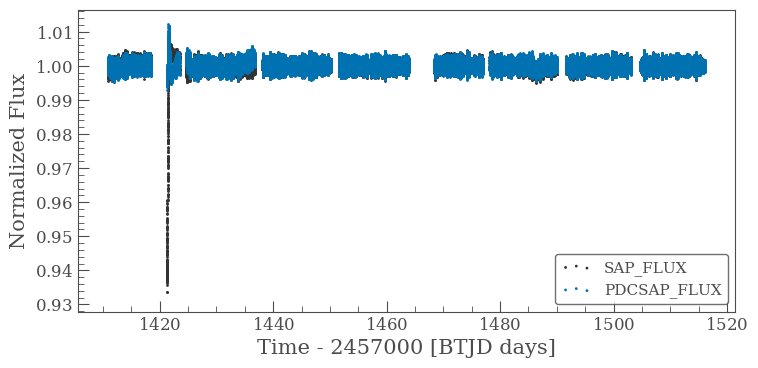

In [9]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)

In [10]:
jds = []
for i in np.arange(2018, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]
['2021-01-01T12:00:00.000']
[2459216.]
['2022-01-01T12:00:00.000']
[2459581.]


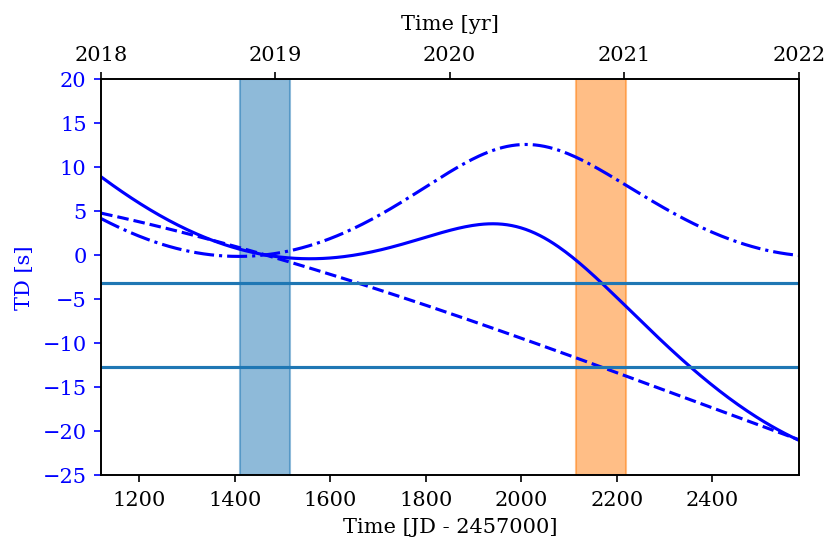

In [11]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)

TESS_mm_tmid = min(times) + (max(times) - min(times))/2

y_tau_b_offset = tau(TESS_mm_tmid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_offset = tau(TESS_mm_tmid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

time_offset = 2457000

fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))


ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns11 = ax1.plot(t_18_22 - time_offset, (y_tau_b + y_tau_c-y_tau_b_offset-y_tau_c_offset) * 86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(t_18_22 - time_offset, (y_tau_b-y_tau_b_offset) * 86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(t_18_22 - time_offset, (y_tau_c-y_tau_c_offset) * 86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")


lns31 = ax1.axvspan(min(times) - time_offset, max(times) - time_offset, alpha=0.5,  label='TESS (mm)', color='C0')
lns32 = ax1.axvspan(min(times)+704 - time_offset, max(times)+704 - time_offset, alpha=0.5,  label='TESS (em)', color='C1')

ax1.set_xlabel('Time [JD - 2457000]')
ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-25,20)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset
t_2022 = jds[4] - time_offset


ax2.set_xticks([t_2018,t_2019,t_2020,t_2021,t_2022])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2018', '2019', '2020', '2021', '2022'], fontsize=10)
ax2.set_xlabel('Time [yr]')
ax2.xaxis.set_label_coords(0.5,1.125)

ax1.axhline((tau(TESS_mm_tmid+704, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)
ax1.axhline((tau(TESS_mm_tmid+704, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)-y_tau_c_offset+tau(TESS_mm_tmid+704, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)

In [37]:
freq, amp = AS(times, mags, 15)

freq=freq[5000:]
amp=amp[5000:]

max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.07, distance=200)

sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

27


In [13]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

In [14]:
#times_pm_em = np.concatenate((times, times+704))

In [15]:
times_pm_em = np.concatenate((times, times+2000*1/10, times+2000*2/10, times+2000*3/10, times+2000*4/10, times+2000*5/10, times+2000*6/10, times+2000*7/10, times+2000*8/10, times+2000*9/10, times+2000*10/10, times+2000*(-1/10), times+2000*(-2/10), times+2000*(-3/10), times+2000*(-4/10), times+2000*(-5/10)))

In [16]:
p_TESS[0]

0.7518889190928036

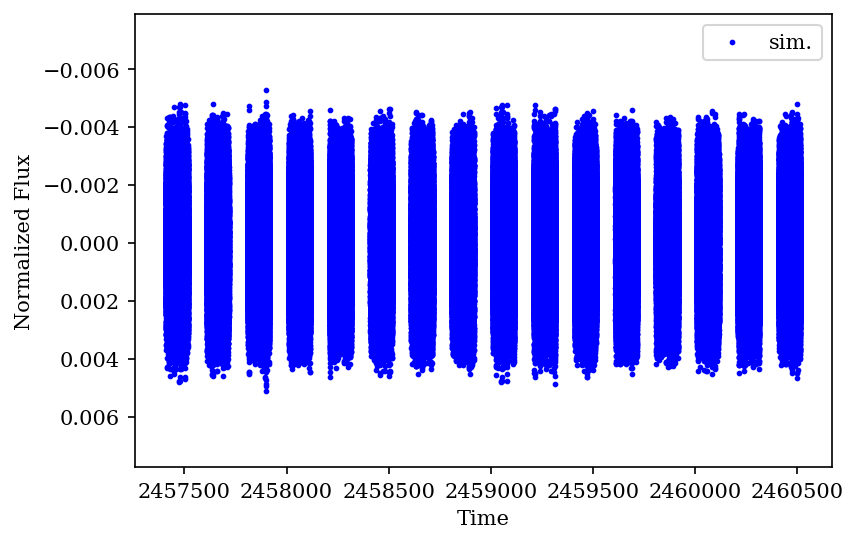

In [17]:
model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_pm_em, 0)#20*np.sqrt(30)*1e-6)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(times_pm_em, model_times[4], s=3, c='b', label = 'sim.')

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.invert_yaxis()

In [18]:
a = times_pm_em[:len(times)]

In [19]:
b = model_times[4][:len(times)]

In [20]:
c = []
d = []
for i in range(10):
    aaa =  np.mean(times_pm_em[len(times)*i:len(times)*(i+1)])
    aa = times_pm_em[len(times)*i:len(times)*(i+1)] - aaa
    a = times_pm_em[len(times)*i:len(times)*(i+1)]
    b = model_times[4][len(times)*i:len(times)*(i+1)]
    c.append(dft_phase(a,b, [f_TESS[0]]))
    d.append(((dft_phase(aa,b, [f_TESS[0]])-2*np.pi*[f_TESS[0]][0]*aaa))%(2*np.pi))

In [21]:
c[0]/6.28

array([0.75067868])

(0, 6.28)

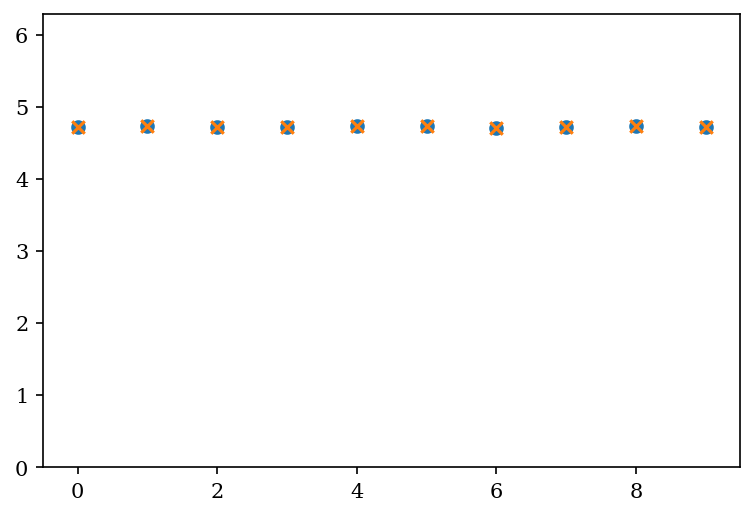

In [22]:
plt.scatter(range(10), c)
plt.scatter(range(10), d, marker = 'x')
plt.ylim(0, 6.28)

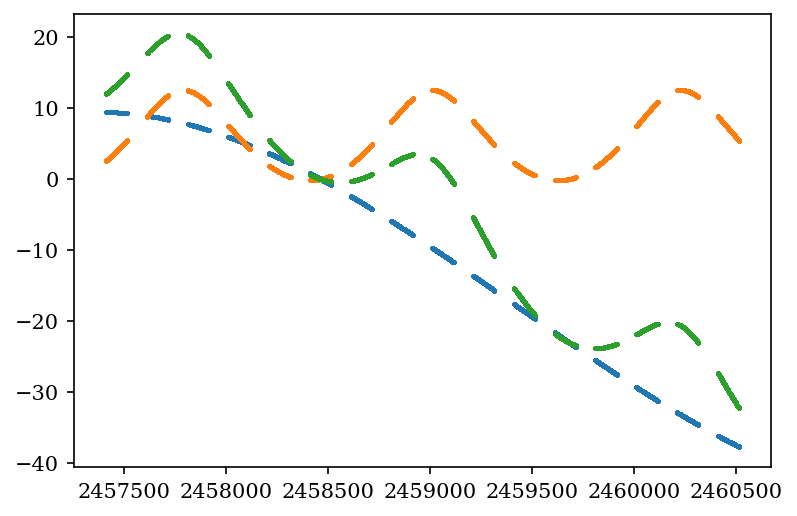

In [23]:
y_tau_b = tau(times_pm_em, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(times_pm_em, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

plt.scatter(times_pm_em, (y_tau_b-y_tau_b_offset)*86400, s=1)
plt.scatter(times_pm_em, (y_tau_c-y_tau_c_offset)*86400, s=1)
plt.scatter(times_pm_em, (y_tau_b + y_tau_c-y_tau_b_offset-y_tau_c_offset)*86400, s=1)

In [24]:
np.arange(0, len(times_pm_em)+len(times), len(times))

array([      0,   64609,  129218,  193827,  258436,  323045,  387654,
        452263,  516872,  581481,  646090,  710699,  775308,  839917,
        904526,  969135, 1033744])

In [25]:
f_TESS

array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 , 48.91898731, 43.52777037, 47.28565013, 57.45201737,
       34.76022934, 38.12894767, 45.26948964, 53.85766147, 51.49607267])

In [26]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

times_run = tBT
magnitudes_run = mBT
segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        

phase = np.unwrap(phase)
phase -= np.mean(phase)
phase = np.array(phase).T
phase_err = np.array(phase_err).T

print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = 2457000

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    leg_errbar.append(lns3)



lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][0]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

CALCULATE TIMES


NameError: name 'tBT' is not defined

In [31]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


times_run = tAT
magnitudes_run = mAT
segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

# times_run = tBT
# magnitudes_run = mBT
# segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16), len(tB15)+len(tB16)+len(tB17)+len(tTESS)])





#AS
freq, amp = AS(times, mags, 15)
freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.1, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))



print('CREATE MULTISINE MODEL')

#Phases
f_TESS = f_TESS[:no_freqs_run]
a_TESS = a_TESS[:no_freqs_run]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

# #model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_run, noise_run)



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run# - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        #print(phase)
        

phase = np.unwrap(phase)
phase -= np.mean(phase)
phase = np.array(phase).T
phase_err = np.array(phase_err).T

print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))


print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = 2457000

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**1)/2)
    leg_errbar.append(lns3)



lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][0]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)

CALCULATE TIMES


NameError: name 'tAT' is not defined

In [ ]:
import os
datadir = os.getcwd() + '/data/'


tTESS, mTESS = np.loadtxt(datadir + 'TESS.txt').T
tB15, mB15 = np.loadtxt(datadir + 'BRITE15.txt').T
tB16, mB16 = np.loadtxt(datadir + 'BRITE16.txt').T
tB17, mB17 = np.loadtxt(datadir + 'BRITE17.txt').T
tA17, mA17 = np.loadtxt(datadir + 'ASTEP17_2048.txt').T
tA18, mA18 = np.loadtxt(datadir + 'ASTEP18_2048.txt').T
tR1, mR1 = np.loadtxt(datadir + 'bRing1.txt').T
tR2, mR2 = np.loadtxt(datadir + 'bRing2.txt').T

In [ ]:
tAT = np.concatenate((tA17, tA18, tTESS))
mAT = np.concatenate((mA17, mA18, mTESS))

tRT = np.concatenate((tR1, tR2, tTESS))
mRT = np.concatenate((mR1, mR2, mTESS))

tBT = np.concatenate((tB15, tB16, tB17, tTESS))
mBT = np.concatenate((mB15, mB16, mB17, mTESS))

In [ ]:
plt.scatter(tAT, mAT)

In [ ]:
plt.scatter(tRT, mRT)

In [ ]:
plt.scatter(tBT, mBT)

In [101]:
#https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
def fit_leastsq_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
    
        def fit_leastsq(p0, datax, datay, function):

            errfunc = lambda p, x, y: function(x,p) - y

            pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

            if (len(datay) > len(p0)) and pcov is not None:
                s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
                pcov = pcov * s_sq
            else:
                pcov = np.inf

            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_leastsq = pfit
            perr_leastsq = np.array(error) 
            return pfit_leastsq, perr_leastsq 

        pfit, perr = fit_leastsq(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

In [102]:
freq, amp = AS(times, mags, 15)

freq=freq[5000:]
amp=amp[5000:]

max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.07, distance=200)

sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

27


In [103]:
f_TESS += 0.00003

CALCULATE TIMES
CALCULATE TIME DELAYS (DATA)
0
[array([0.01145374, 3.92948057, 2.81211432, 0.52111071, 2.46979726,
       3.63892554, 4.47014902, 1.42218069, 4.47648356, 5.50466854,
       5.87898531, 5.42874148, 0.03881183, 0.73968406, 1.72465246,
       1.79901416, 2.81292118, 5.3046949 , 4.05123607, 0.55470305,
       4.9720242 , 6.09849058, 5.33672518, 5.82141804, 4.86721003,
       5.56020266, 0.28197293])]
1
[array([0.01145374, 3.92948057, 2.81211432, 0.52111071, 2.46979726,
       3.63892554, 4.47014902, 1.42218069, 4.47648356, 5.50466854,
       5.87898531, 5.42874148, 0.03881183, 0.73968406, 1.72465246,
       1.79901416, 2.81292118, 5.3046949 , 4.05123607, 0.55470305,
       4.9720242 , 6.09849058, 5.33672518, 5.82141804, 4.86721003,
       5.56020266, 0.28197293]), array([6.27767905, 3.89199927, 2.77345144, 0.50122212, 2.43350339,
       3.60964826, 4.46184762, 1.39311177, 3.75363874, 5.46400838,
       5.85607465, 5.40708886, 0.02951289, 0.39198144, 1.55519771,
       1.759

[array([0.01145374, 3.92948057, 2.81211432, 0.52111071, 2.46979726,
       3.63892554, 4.47014902, 1.42218069, 4.47648356, 5.50466854,
       5.87898531, 5.42874148, 0.03881183, 0.73968406, 1.72465246,
       1.79901416, 2.81292118, 5.3046949 , 4.05123607, 0.55470305,
       4.9720242 , 6.09849058, 5.33672518, 5.82141804, 4.86721003,
       5.56020266, 0.28197293]), array([6.27767905, 3.89199927, 2.77345144, 0.50122212, 2.43350339,
       3.60964826, 4.46184762, 1.39311177, 3.75363874, 5.46400838,
       5.85607465, 5.40708886, 0.02951289, 0.39198144, 1.55519771,
       1.75996192, 1.41610028, 5.21980774, 3.31897638, 3.20977246,
       4.84931074, 0.75727118, 1.69344401, 2.14992386, 4.26014819,
       4.43860538, 3.80073809]), array([6.23726346, 3.86248635, 2.75211708, 0.48169893, 2.40111283,
       3.60961317, 4.41742248, 1.40220981, 3.68812891, 5.44517896,
       5.82295291, 5.38633179, 6.22956794, 0.21582746, 1.6857025 ,
       1.69286984, 0.57327192, 5.23264263, 2.03777573, 1.97475

[array([0.01145374, 3.92948057, 2.81211432, 0.52111071, 2.46979726,
       3.63892554, 4.47014902, 1.42218069, 4.47648356, 5.50466854,
       5.87898531, 5.42874148, 0.03881183, 0.73968406, 1.72465246,
       1.79901416, 2.81292118, 5.3046949 , 4.05123607, 0.55470305,
       4.9720242 , 6.09849058, 5.33672518, 5.82141804, 4.86721003,
       5.56020266, 0.28197293]), array([6.27767905, 3.89199927, 2.77345144, 0.50122212, 2.43350339,
       3.60964826, 4.46184762, 1.39311177, 3.75363874, 5.46400838,
       5.85607465, 5.40708886, 0.02951289, 0.39198144, 1.55519771,
       1.75996192, 1.41610028, 5.21980774, 3.31897638, 3.20977246,
       4.84931074, 0.75727118, 1.69344401, 2.14992386, 4.26014819,
       4.43860538, 3.80073809]), array([6.23726346, 3.86248635, 2.75211708, 0.48169893, 2.40111283,
       3.60961317, 4.41742248, 1.40220981, 3.68812891, 5.44517896,
       5.82295291, 5.38633179, 6.22956794, 0.21582746, 1.6857025 ,
       1.69286984, 0.57327192, 5.23264263, 2.03777573, 1.97475

[array([0.01145374, 3.92948057, 2.81211432, 0.52111071, 2.46979726,
       3.63892554, 4.47014902, 1.42218069, 4.47648356, 5.50466854,
       5.87898531, 5.42874148, 0.03881183, 0.73968406, 1.72465246,
       1.79901416, 2.81292118, 5.3046949 , 4.05123607, 0.55470305,
       4.9720242 , 6.09849058, 5.33672518, 5.82141804, 4.86721003,
       5.56020266, 0.28197293]), array([6.27767905, 3.89199927, 2.77345144, 0.50122212, 2.43350339,
       3.60964826, 4.46184762, 1.39311177, 3.75363874, 5.46400838,
       5.85607465, 5.40708886, 0.02951289, 0.39198144, 1.55519771,
       1.75996192, 1.41610028, 5.21980774, 3.31897638, 3.20977246,
       4.84931074, 0.75727118, 1.69344401, 2.14992386, 4.26014819,
       4.43860538, 3.80073809]), array([6.23726346, 3.86248635, 2.75211708, 0.48169893, 2.40111283,
       3.60961317, 4.41742248, 1.40220981, 3.68812891, 5.44517896,
       5.82295291, 5.38633179, 6.22956794, 0.21582746, 1.6857025 ,
       1.69286984, 0.57327192, 5.23264263, 2.03777573, 1.97475

[array([0.01145374, 3.92948057, 2.81211432, 0.52111071, 2.46979726,
       3.63892554, 4.47014902, 1.42218069, 4.47648356, 5.50466854,
       5.87898531, 5.42874148, 0.03881183, 0.73968406, 1.72465246,
       1.79901416, 2.81292118, 5.3046949 , 4.05123607, 0.55470305,
       4.9720242 , 6.09849058, 5.33672518, 5.82141804, 4.86721003,
       5.56020266, 0.28197293]), array([6.27767905, 3.89199927, 2.77345144, 0.50122212, 2.43350339,
       3.60964826, 4.46184762, 1.39311177, 3.75363874, 5.46400838,
       5.85607465, 5.40708886, 0.02951289, 0.39198144, 1.55519771,
       1.75996192, 1.41610028, 5.21980774, 3.31897638, 3.20977246,
       4.84931074, 0.75727118, 1.69344401, 2.14992386, 4.26014819,
       4.43860538, 3.80073809]), array([6.23726346, 3.86248635, 2.75211708, 0.48169893, 2.40111283,
       3.60961317, 4.41742248, 1.40220981, 3.68812891, 5.44517896,
       5.82295291, 5.38633179, 6.22956794, 0.21582746, 1.6857025 ,
       1.69286984, 0.57327192, 5.23264263, 2.03777573, 1.97475

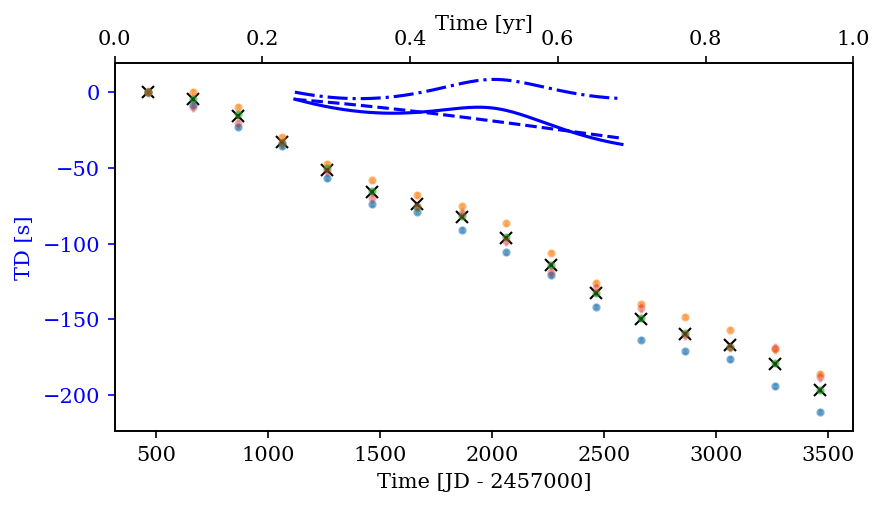

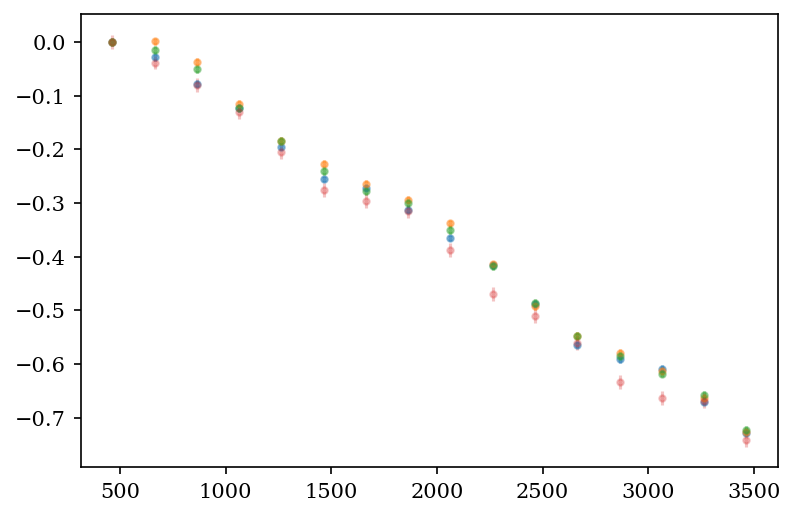

In [111]:
no_freqs_run = 4
no_freqs_run_weighted = 4


print('CALCULATE TIMES')


# times_run = tAT
# magnitudes_run = mAT
# segment_borders = np.array([0, len(tA17), len(tA17)+len(tA18), len(tA17)+len(tA18)+len(tTESS)])

# times_run = tRT
# magnitudes_run = mRT
# segment_borders = np.array([0, len(tR1), len(tR1)+len(tR2), len(tR1)+len(tR2)+len(tTESS)])

times_run = times_pm_em
magnitudes_run = model_times[4]
segment_borders = np.arange(0, len(times_pm_em)+len(times), len(times))



print('CALCULATE TIME DELAYS (DATA)')

times_TD = times_run - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        #print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        print(phase)
        
phase = np.array(phase)

mean_phase = np.mean(phase)
phase[np.where(phase - mean_phase > np.pi/2)] -= np.pi
phase[np.where(phase - mean_phase < -np.pi/2)] += np.pi

phase = np.unwrap(phase)
phase -= np.mean(phase)
phase = np.array(phase).T
phase_err = np.array(phase_err).T


#print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

    
    

print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)


print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = 2457000

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset


ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')



ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[-1] - y_tau_c_sim[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, (td_weighted-td_weighted[-1])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**1)/2)
    leg_errbar.append(lns3)
    
#ax1.set_ylim(-50, 30)


lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]


fig.tight_layout()
plt.show()

t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][0]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400


for i in range(no_freqs_run):
    plt.errorbar(np.array(time_midpoints) - time_offset, (phase[i]-phase[i][-1]), yerr = phase_err[i], fmt='.', alpha = ((a_TESS[i]/a_TESS[0]))/2)
    #plt.ylim(-2, 2)